### Necessary Imports

In [1]:
import os
import sys
import warnings

parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)

import numpy as np
import torch
import soundfile as sf
from colorama import Fore
from IPython.display import display, Audio
from src import CustomUNet
import matplotlib.pyplot as plt
from numpy.random import MT19937
from data import AudioSplitter, convert_to_spectrogram
from numpy.random import RandomState, SeedSequence

rs = RandomState(MT19937(SeedSequence(42)))
warnings.filterwarnings("ignore")
plt.style.use("default")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Inference on an unseen noisy audio

In [2]:
# Create an instance of the model
model = CustomUNet(input_shape=(1, 256, 512), num_classes=1)
model.to(torch.device("cpu"))

# Load the weights from the .pth file
model.load_state_dict(torch.load("best_model.pt"))

# Set the model to evaluation mode
model.eval()

assert (
    os.listdir("samples") != []
), "Add some .wav files to the samples/ folder to run the inference."

In [3]:
# provide a graphing user interface to select the file
from tkinter import Tk
from tkinter.filedialog import askopenfilename

Tk().withdraw()
filename = askopenfilename(
    initialdir=os.path.join(os.getcwd(), "samples"),
    title="Select a file",
    filetypes=(("wav files", "*.wav"), ("all files", "*.*")),
)

In [4]:
# Define some constants
sr = 16000
speech_length_pix_sec = 27e-3
total_length = 3.6
trim_length = 56800
n_fft = 510
frame_length = 510
frame_step = 110

# Define the L1 loss function
mae = torch.nn.L1Loss()

Create audio chunks

In [5]:
splitter = AudioSplitter(
    chunk_size=trim_length,
)

tensor_chunks = splitter.get_tensor_chunks(filename)

In [6]:
# Initialize some arrays to store results
wav_corrupt_array = np.zeros((len(tensor_chunks), trim_length))
wav_correct_array = np.zeros((len(tensor_chunks), trim_length))
spec_corrupt_array = np.zeros((len(tensor_chunks), 256, 512))
spec_correct_array = np.zeros((len(tensor_chunks), 256, 512))

In [7]:
def denoise_audio(
    wav, model, n_fft=2048, frame_length=2048, frame_step=512, trim_length=66150
):
    # Convert the waveform to a spectrogram
    corr = convert_to_spectrogram(wav).unsqueeze(0)

    # Convert corrupted and clean spectrograms to waveforms
    corr_wav = torch.istft(
        corr[0, :, :],
        n_fft=n_fft,
        hop_length=frame_step,
        win_length=frame_length,
        onesided=True,
        length=trim_length,
    )

    # Convert corrupted spectrogram to numpy array and compute its magnitude
    corr = corr.detach().cpu().numpy()
    corr_amp = np.abs(corr)

    # Apply the model to the corrupted spectrogram
    corrected_amp = model(torch.from_numpy(np.expand_dims(corr_amp, axis=0)))
    corrected_spec = corrected_amp * np.exp(1j * np.angle(np.expand_dims(corr, 0)))

    # Convert the corrected spectrogram to a waveform
    corrected_wav = torch.istft(
        corrected_spec[0, 0, :, :],
        n_fft=n_fft,
        hop_length=frame_step,
        win_length=frame_length,
        onesided=True,
        length=trim_length,
    )

    return (
        corr_wav,
        corrected_wav,
        np.abs(corr[0, :, :]),
        corrected_amp[0, 0, :, :].numpy(),
    )


# Disable gradient calculation for efficiency
with torch.no_grad():
    for ind, chunk in enumerate(tensor_chunks):
        # Store the waveforms and spectrograms in the arrays
        (
            wav_corrupt_array[ind],
            wav_correct_array[ind],
            spec_corrupt_array[ind],
            spec_correct_array[ind],
        ) = denoise_audio(
            chunk,
            model,
            n_fft=n_fft,
            frame_length=frame_length,
            frame_step=frame_step,
            trim_length=trim_length,
        )

In [8]:
# Concatenate the waveforms
wav_corrupt = np.concatenate(wav_corrupt_array)
wav_correct = np.concatenate(wav_correct_array)

# Concatenate the spectrograms
spec_corrupt = np.concatenate(spec_corrupt_array, axis=1)
spec_correct = np.concatenate(spec_correct_array, axis=1)

In [9]:
import tempfile

with tempfile.TemporaryDirectory() as temp_dir:
    corrupt_file = os.path.join(temp_dir, "corrupt.wav")
    corrected_file = os.path.join(temp_dir, "correct.wav")
    sf.write(
        corrupt_file,
        np.concatenate(wav_corrupt_array),
        samplerate=sr,
    )
    sf.write(
        corrected_file,
        np.concatenate(wav_correct_array),
        samplerate=sr,
    )
    print(f"{Fore.LIGHTCYAN_EX}Corrupted Audio >> {Fore.RESET}")
    display(Audio(corrupt_file))
    print(f"{Fore.LIGHTRED_EX}Corrected Audio >> {Fore.RESET}")
    display(Audio(corrected_file))

Corrupted Audio >> 


Corrected Audio >> 


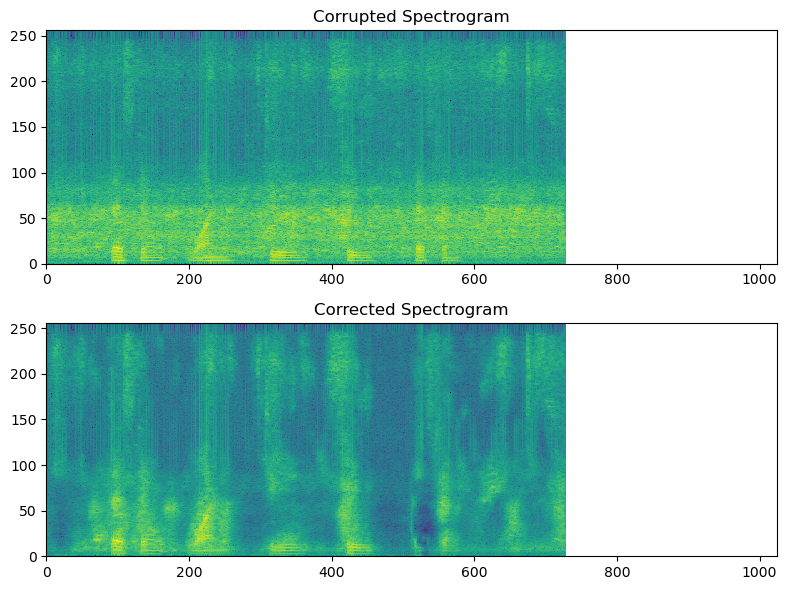

In [10]:
# Plot the spectrograms
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.pcolormesh(np.log(spec_corrupt))
plt.title("Corrupted Spectrogram")
plt.subplot(2, 1, 2)
plt.pcolormesh(np.log(spec_correct))
plt.title("Corrected Spectrogram")
plt.tight_layout()
plt.show()